In [1]:
import pandas as pd
import re
from datetime import datetime

def parse_lines(lines):
    #"%h %l %u %t \"%r\" %>s %b" - apache log format
    b = '(-|\d+)'
    s = '(-|\d{3})'
    h = '(.+) '
    l = '(-|\w+)'
    u = '(-|\w+)'
    t = '\[([\w:/\- ]+)\]'
    r = '\"(GET|HEAD|POST|PUT|DELETE|CONNECT|OPTIONS|TRACE) (.+)( HTTP/1\.\d)?\"'
    pattern = '^' + h + l + ' ' + u + ' ' + t  + ' ' + r + ' ' +  s + ' ' + b +'$'
    regexp = re.compile(pattern)
    result = {'host':[], 'time':[], 'path':[], 'size':[], 'uri':[]}
    for line in lines:
        line = line.rstrip()
        match =  regexp.match(line)
        if match:
            (host, _, __, time, ___, path, version, ____, size) = match.groups()
            path = path.split(' ')[0]
            result['host'].append(host)
            time = datetime.strptime(time, '%d/%b/%Y:%H:%M:%S %z')
            result['time'].append(time)
            result['path'].append(path)
            result['size'].append(size)
            result['uri'].append(host + path)
        else:
            print('warning: "%s" missmatch' %line)
    
    return result

In [2]:
import requests

API_ENDPOINT = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={}'

def get_direct_link(link):
    request = requests.get(API_ENDPOINT.format(link))
    return request.json()['href']

In [7]:
import urllib
import zipfile
import os

filename = 'access_log_Jul95.log'

# Check if file exitsts

if not os.path.isfile(filename):
    link = get_direct_link('https://yadi.sk/d/JPx8Chjc6hLHNg')
    print('Downloading archive from %s' % link)
    urllib.request.urlretrieve (link, 'archive.zip')
    archive = zipfile.ZipFile('archive.zip', 'r')
    print('Extracting file %s' % filename)
    data = archive.extract(filename)


In [6]:
print('Processing file %s' % filename)
with open(filename, 'r', encoding = "ISO 8859-1") as data:
    result = parse_lines(data)
    df1 = pd.DataFrame(data=result)
    df1.head(15)

In [8]:
df1.head(3)

,host,time,path,size,uri
0,199.72.81.55,1995-07-01 00:00:01-04:00,/history/apollo/,6245,199.72.81.55/history/apollo/
1,unicomp6.unicomp.net,1995-07-01 00:00:06-04:00,/shuttle/countdown/,3985,unicomp6.unicomp.net/shuttle/countdown/
2,199.120.110.21,1995-07-01 00:00:09-04:00,/shuttle/missions/sts-73/mission-sts-73.html,4085,199.120.110.21/shuttle/missions/sts-73/mission...


In [9]:
#посчитать количество обращений к каждому урлу;
counts = df1['uri'].value_counts()

In [10]:
#найти топ-15 самых посещаемых урлов;
import numpy as np
for i in np.arange(0, 14):
    print(counts[counts == counts[i]])

siltb10.orl.mmc.com/images/KSC-logosmall.gif    2549
Name: uri, dtype: int64
siltb10.orl.mmc.com/images/launch-logo.gif    2541
Name: uri, dtype: int64
siltb10.orl.mmc.com/history/apollo/images/apollo-logo1.gif    2479
Name: uri, dtype: int64
currypc.fpl.msstate.edu/htbin/cdt_main.pl    1917
Name: uri, dtype: int64
piweba3y.prodigy.com/shuttle/missions/sts-71/sts-71-patch-small.gif    1116
Name: uri, dtype: int64
piweba3y.prodigy.com/images/NASA-logosmall.gif    1010
Name: uri, dtype: int64
bill.ksc.nasa.gov/htbin/cdt_main.pl    1006
Name: uri, dtype: int64
bill.ksc.nasa.gov/images/NASA-logosmall.gif    1003
Name: uri, dtype: int64
piweba3y.prodigy.com/images/KSC-logosmall.gif    957
Name: uri, dtype: int64
bill.ksc.nasa.gov/shuttle/countdown/images/cdtclock.gif    928
Name: uri, dtype: int64
helios.astro.uva.nl/shuttle/countdown/video/livevideo.jpeg    861
Name: uri, dtype: int64
edams.ksc.nasa.gov/ksc.html    789
Name: uri, dtype: int64
piweba3y.prodigy.com/shuttle/missions/sts-70/st

In [11]:
#посчитать число запросов в секунду;
times = df1['time']
counts = df1.shape[0]
seconds = (times[-1]-times[0]).total_seconds()
print(counts/seconds)

0.7943204072652027


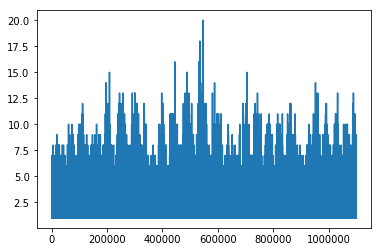

In [13]:
#нарисовать график числа запросов в секунду;
data = np.asarray(df1.groupby(df1["time"]).size().tolist())
import matplotlib.pyplot as plt
plt.plot(data)

In [14]:
#построить гистограмму распределения размеров запросов.

(array([6155., 2787.,  784.,  371.,  250.,  185.,  158.,  130.,  109.,
          94.,   82.,   77.,   57.,   70.,   43.,   58.,   47.,   42.,
          32.,   40.,   32.,   31.,   47.,   37.,   34.,   24.,   20.,
          20.,   24.,   20.,   25.,   29.,   18.,   18.,   20.,   27.,
          21.,    9.,   24.,   14.,   12.,   21.,    9.,   14.,   14.,
          12.,    7.,    7.,   17.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

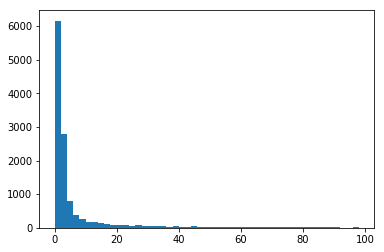

In [15]:
data = np.asarray(df1.groupby(df1["size"]).size().tolist())
bins = np.arange(0, 100, 2)
plt.hist(data, bins=bins)